<a href="https://colab.research.google.com/github/gimmethatcode/data_projects/blob/main/TV_Human_Interaction_3D_Anastasios_Gialamas_MasterThesis_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load videos from local drive

In [ ]:
# load files
from google.colab import files
uploaded = files.upload()

Saving handShake_0001.avi to handShake_0001.avi
Saving handShake_0002.avi to handShake_0002.avi
Saving handShake_0003.avi to handShake_0003.avi
Saving handShake_0004.avi to handShake_0004.avi
Saving handShake_0005.avi to handShake_0005.avi
Saving handShake_0006.avi to handShake_0006.avi
Saving handShake_0007.avi to handShake_0007.avi
Saving handShake_0008.avi to handShake_0008.avi
Saving handShake_0009.avi to handShake_0009.avi
Saving handShake_0010.avi to handShake_0010.avi
Saving handShake_0011.avi to handShake_0011.avi
Saving handShake_0012.avi to handShake_0012.avi
Saving handShake_0013.avi to handShake_0013.avi
Saving handShake_0014.avi to handShake_0014.avi
Saving handShake_0015.avi to handShake_0015.avi
Saving handShake_0016.avi to handShake_0016.avi
Saving handShake_0017.avi to handShake_0017.avi
Saving handShake_0018.avi to handShake_0018.avi
Saving handShake_0019.avi to handShake_0019.avi
Saving handShake_0020.avi to handShake_0020.avi
Saving handShake_0021.avi to handShake_0

In [ ]:
# create directory
import os
if not os.path.exists('tv_human_interactions_videos'):
  os.mkdir('tv_human_interactions_videos')


In [ ]:
# move video to working directory
import glob
import shutil
for video in glob.glob('*.avi'):
  shutil.move(video, 'tv_human_interactions_videos/' + video)

# Prepare dataset

In [ ]:
# import libraries
import cv2
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Init datasets variables
FRAMES_PER_VIDEO = 24
FRAME_HEIGHT = 256
FRAME_WIDTH = 256
FRAME_CHANNEL = 3
NUM_CLASSES = 5
BATCH_SIZE = 1
EPOCHS = 5

# DATA_AUGMENTATION = []
DATA_AUGMENTATION = ['flip_frame', 'increase_brightness']
# DATA_AUGMENTATION = ['increase_brightness', 'decrease_brightness', 'add_sharpening', 'flip_frame'] # max 4 type of data augmentation available

INPUT_FOLDER = 'tv_human_interactions_videos'

In [ ]:
 fps_lst = [] # frame per second
 nbf_lst = [] # total number of frame
 len_lst = [] # video duration
 for vid in glob.glob(INPUT_FOLDER + "/*.avi"):
  # open video
  cap = cv2.VideoCapture(vid)

  fps_lst.append(cap.get(cv2.CAP_PROP_FPS))
  nbf_lst.append(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  len_lst.append(cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS))

import statistics

print("mean number of frame per seconds:", statistics.mean(fps_lst), "+/-", statistics.stdev(fps_lst))

mean number of frame per seconds: 24.102282727182303 +/- 0.3372777052607856


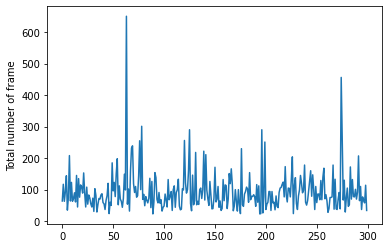

In [ ]:
import matplotlib.pyplot as plt

plt.plot(nbf_lst)
plt.ylabel('Total number of frame')
plt.show()

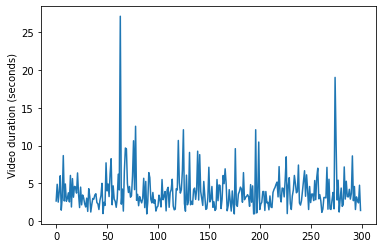

In [ ]:
plt.plot(len_lst)
plt.ylabel('Video duration (seconds)')
plt.show()

In [ ]:
# Explanation
# All videos are close to a mean of 24 frame per seconds. However videos duration and number of frames fluctuates at lot between each of the clips
# Therefore keeping videos with a least one second duration -> 24 fps and filtered the rest

In [ ]:
# feed function with input folder and return dataframe for train and test
# contains path to load video, int(class), str(name)
def get_data_list(input_folder):
    # get list of video in input folder
    video_list = glob.glob(input_folder + '/*')
    
    # init list
    interaction_list = []

    # iteration through video list
    for video in video_list: 
        # look for training label video name
        if 'handShake' in video:
            interaction_list.append([video, 0, 'handShake'])
        elif 'highFive' in video:
            interaction_list.append([video, 1, 'highFive'])
        elif 'hug' in video:
            interaction_list.append([video, 2, 'hug'])
        elif 'kiss' in video:
            interaction_list.append([video, 3, 'kiss'])
        elif 'negative' in video:
            interaction_list.append([video, 4, 'negative'])
    
    # shuffle dataset and breaks it into trainset and testset
    random.shuffle(interaction_list)
    print('train set size: ' + str(len(interaction_list)))
    # 50 clips kept aside for prediction only
    train_interaction = interaction_list[:len(interaction_list)-50]
    test_interaction = interaction_list[len(interaction_list)-50:]
   
    # print some info
    print('train set size: ' + str(len(train_interaction)))
    print('test set size: ' + str(len(test_interaction)))
    
    # convert list to dataframe
    train_df = pd.DataFrame(train_interaction, columns=['path', 'class', 'interaction'])
    test_df = pd.DataFrame(test_interaction, columns=['path', 'class', 'interaction'])
    
    return train_df, test_df


# Function to insert row in the dataframe 
def insert_row_df(row_number, df, row_value): 
	# Slice the upper half of the dataframe 
	df1 = df[0:row_number] 

	# Store the result of lower half of the dataframe 
	df2 = df[row_number:] 

	# Inser the row in the upper half dataframe 
	df1.loc[row_number]=row_value 

	# Concat the two dataframes 
	df_result = pd.concat([df1, df2])

	# Reassign the index labels 
	df_result.index = [*range(df_result.shape[0])] 

	# Return the updated dataframe 
	return df_result 


In [ ]:
# get total number of frame in the video
def get_nb_frame(vid):
  # open video
  cap = cv2.VideoCapture(vid)

  # cnt number of frame
  cnt_frame = 0

  # get number of frame
  ret = True
  while ret:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # stop loop when necessary
    if not ret:
      continue

    # increase count by one
    cnt_frame += 1

  return cnt_frame


# get total number of frame in the video
def get_video_frame_info(vid):
  # open video
  cap = cv2.VideoCapture(vid)

  # cnt number of frame
  cnt_frame = 0

  # frame list
  idx_list = []
  frame_list = []

  # get number of frame
  ret = True
  while ret:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # stop loop when necessary
    if not ret:
      continue

    # add idx to list
    idx_list.append(cnt_frame)

    # add frame to list
    frame_list.append(frame)

    # increase count by one
    cnt_frame += 1

  # return cnt_frame
  return idx_list, frame_list 


# data augmentation per frame
def augmentation_frame(augmentation_lis, frame):
  frame_inc_bright = []
  frame_dec_bright = [] 
  sharpened_frame = []
  flip_frame = []

  for augmentation in DATA_AUGMENTATION:
    # increase brightness
    if augmentation == 'increase_brightness':
      bright = np.ones(frame.shape, dtype='uint8')*70
      frame_inc_bright = cv2.add(frame, bright).astype(np.uint8)
      if FRAME_CHANNEL == 1: # add one dimension for channel number in case of one -> (256,256,1) instead of (256,256)
        frame_inc_bright = np.expand_dims(frame_inc_bright, axis=-1)

    # decrease brightness
    elif augmentation == 'decrease_brightness':
      bright = np.ones(frame.shape, dtype='uint8')*70
      frame_dec_bright = cv2.subtract(frame, bright)
      if FRAME_CHANNEL == 1: # add one dimension for channel number in case of one -> (256,256,1) instead of (256,256)
        frame_dec_bright = np.expand_dims(frame_dec_bright, axis=-1)

    # add sharpening on the image
    elif augmentation == 'add_sharpening':
      # define sharpening matrix
      sharpening = np.array([ [-1, -1, -1],
                              [-1, 10, -1],
                              [-1, -1, -1] ])
      sharpened_frame = cv2.filter2D(frame, -1, sharpening)
      if FRAME_CHANNEL == 1: # add one dimension for channel number in case of one -> (256,256,1) instead of (256,256)
        sharpened_frame = np.expand_dims(sharpened_frame, axis=-1)

    # flip frames
    elif augmentation == 'flip_frame':
      flip_frame = cv2.flip(frame, 3) # vertical flipping
      if FRAME_CHANNEL == 1: # add one dimension for channel number in case of one -> (256,256,1) instead of (256,256)
        flip_frame = np.expand_dims(flip_frame, axis=-1)

  return frame_inc_bright, frame_dec_bright, sharpened_frame, flip_frame
  

In [ ]:
# feed this function with a list of data organized as path class interaction
# return dataset and matched label array (categorized)
def get_data_set(data_list, show_case = False):
    data_path = data_list['path']
    data_classes = data_list['class']
    classes_augmentation = data_list['class']

    # iterate through all video
    cnt = 0
    clean_data_path = []
    clean_data_classes = []
    clean_classes_augmentation = []
    for idx_vid, vid in enumerate(data_path):
        # list with idx and all frames from video
        nb_frame = get_nb_frame(vid)
        # do not add video when to short
        if nb_frame < FRAMES_PER_VIDEO:
          cnt += 1
          continue
        # kept only videos of interest
        clean_data_path.append(vid)
        clean_data_classes.append(data_classes[idx_vid])
        clean_classes_augmentation.append(classes_augmentation[idx_vid])

    print("Preprocessing done.", cnt, "video(s) removed")

    # convert lists to dataframe
    # clean_data_path = pd.DataFrame(clean_data_path)
    # clean_data_classes = pd.DataFrame(clean_data_classes)
    clean_classes_augmentation = pd.DataFrame(clean_classes_augmentation)

    # list to store video arrays and class for each frame
    videos = []
    class_videos = []

    # count videos
    idx_augmentation = 0
    # iterate through all video
    for idx_vid, vid in enumerate(clean_data_path):
        # list with idx and all frames from video
        frame_idx_list, list_of_frames = get_video_frame_info(vid)

        # get random frames list
        rand_idx_list = random.sample(frame_idx_list, FRAMES_PER_VIDEO) 
        # keep them in order
        rand_idx_list.sort()

        # get all frame
        frames = [] 
        # init data augmentation if necessary
        if DATA_AUGMENTATION:
          frame_inc_bright = []
          frame_dec_bright = []
          frame_sharpened = []
          frame_flipped = []

        for idx in rand_idx_list:
            # resize and add frame to frame list
            frame = list_of_frames[idx]
            
            if FRAME_CHANNEL == 1: # one channel -> convert to gray scale
              frame_resized = cv2.cvtColor(cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH)), cv2.COLOR_BGR2GRAY).astype(np.uint8)
              frame_resized = np.expand_dims(frame_resized, axis=-1)
            else: # channel apply resize only
              frame_resized = cv2.cvtColor(cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH)), cv2.COLOR_BGR2RGB).astype(np.uint8)

            # add init frame to frames list
            frames.append(frame_resized)

            # iterate through data augmentation method
            if DATA_AUGMENTATION:
              frame_inc, frame_dec, sharpened_frame, flip_frame = augmentation_frame(DATA_AUGMENTATION, frame_resized)
              # add to list
              frame_inc_bright.append(frame_inc)
              frame_dec_bright.append(frame_dec)
              frame_sharpened.append(sharpened_frame)
              frame_flipped.append(flip_frame)

        # add initialized clip to videos list            
        videos.append(np.array(frames))
        if idx_vid == 0 and show_case:
          print('\n\n\nOriginal Frames\n')
          vid_ = np.array(frames)
          for i in range(3):
            frame_ = vid_[vid_.shape[0] // 2 + i]
            plt.imshow(frame_)
            plt.show()

        # add data augmentation to video list
        # for each method add clip to its list and add class
        for augmentation in DATA_AUGMENTATION:
          # increase brightness
          if augmentation == 'increase_brightness':
            idx_augmentation += 1
            videos.append(np.array(frame_inc_bright))
            clean_classes_augmentation = insert_row_df(idx_augmentation, clean_classes_augmentation, clean_data_classes[idx_vid])
            if idx_vid == 0 and show_case:
              print('\n\n\Increase Brightness\n')
              vid_ = np.array(frame_inc_bright) 
              for i in range(3):
                frame_ = vid_[vid_.shape[0] // 2 + i]
                plt.imshow(frame_)
                plt.show()

          # decrease brightness
          elif augmentation == 'decrease_brightness':
            idx_augmentation += 1           
            videos.append(np.array(frame_dec_bright))
            clean_classes_augmentation = insert_row_df(idx_augmentation, clean_classes_augmentation, clean_data_classes[idx_vid])
            if idx_vid == 0 and show_case:
              print('\n\n\nDecrease Brightness\n')
              vid_ = np.array(frame_dec_bright) 
              for i in range(3):
                frame_ = vid_[vid_.shape[0] // 2 + i]
                plt.imshow(frame_)
                plt.show()

          # add sharpening
          elif augmentation == 'add_sharpening':
            idx_augmentation += 1           
            videos.append(np.array(frame_sharpened))
            clean_classes_augmentation = insert_row_df(idx_augmentation, clean_classes_augmentation, clean_data_classes[idx_vid])
            if idx_vid == 0 and show_case:
              print('\n\n\nSharpening Frames\n')
              vid_ = np.array(frame_sharpened) 
              for i in range(3):
                frame_ = vid_[vid_.shape[0] // 2 + i]
                plt.imshow(frame_)
                plt.show()

          # add sharpening
          elif augmentation == 'flip_frame':
            idx_augmentation += 1           
            videos.append(np.array(frame_flipped))
            clean_classes_augmentation = insert_row_df(idx_augmentation, clean_classes_augmentation, clean_data_classes[idx_vid])  
            if idx_vid == 0 and show_case:
              print('\n\n\nFlipped Frames\n')
              vid_ = np.array(frame_flipped) 
              for i in range(3):
                frame_ = vid_[vid_.shape[0] // 2 + i]
                plt.imshow(frame_)
                plt.show()

    # convert class array to one hot vector
    data_labels = tf.keras.utils.to_categorical(clean_classes_augmentation.astype(np.uint8))

    # convert list of array to array of array
    data_set = np.array(videos)

    # print dataset dim info
    print('data_label: ' + str(data_labels.shape))
    print('data_set: ' + str(data_set.shape))
    
    # return array of clip initizalied and matching dataset
    return data_set, data_labels

input_folder: tv_human_interactions_videos
train set size: 300
train set size: 250
test set size: 50

train_list:
Preprocessing done. 2 video(s) removed



Original Frames



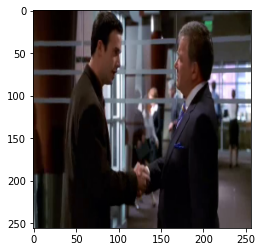

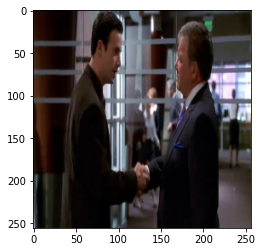

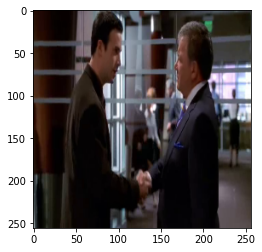

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)





Flipped Frames



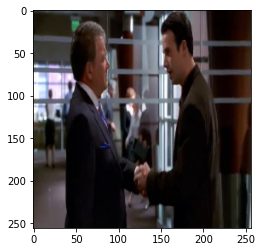

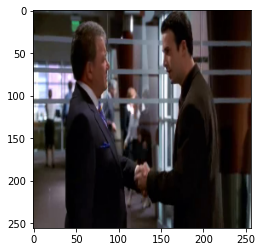

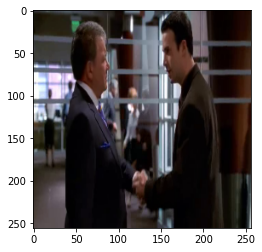



\Increase Brightness



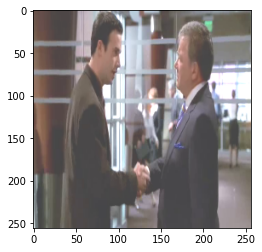

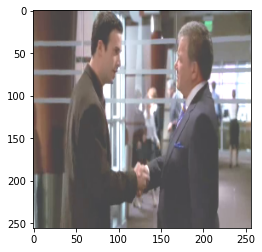

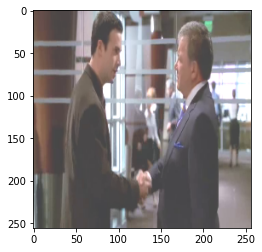

data_label: (744, 5)
data_set: (744, 24, 256, 256, 3)

test_list:
Preprocessing done. 0 video(s) removed
data_label: (150, 5)
data_set: (150, 24, 256, 256, 3)


In [ ]:
print('input_folder: ' + INPUT_FOLDER)
train_list, test_list = get_data_list(INPUT_FOLDER)

print('\ntrain_list:')
train_set, train_labels = get_data_set(train_list, True)

print('\ntest_list:')
test_set, test_labels = get_data_set(test_list)

In [ ]:
 # split train sets into trains and tests
X_train, X_test, Y_train, Y_test = train_test_split(train_set, train_labels, test_size=0.10)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(669, 24, 256, 256, 3)
(669, 5)
(75, 24, 256, 256, 3)


# 3D CNN model

In [ ]:
# init
# provides training and inference features for the model
model = tf.keras.Sequential()

# 3Dconv layer with input_shape = to one clip size
# no number of clip defined (use None) so we can feed the network with how many input clip we want at once
model.add(tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=[FRAMES_PER_VIDEO,FRAME_HEIGHT,FRAME_WIDTH,FRAME_CHANNEL]))

# apply maxPooling 3D
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

# apply batch normalization
model.add(tf.keras.layers.BatchNormalization())

# dropout prevent over fitting
model.add(tf.keras.layers.Dropout(0.5))

# a 2nd conv3D layer (can be as many as we want)
model.add(tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

# flatten 3D matrix to 1D vector
model.add(tf.keras.layers.Flatten())

# 2 dense layer (because 2 3Dconv)
# dot product(input, kernel) + bias
# activation function -> relu
model.add(tf.keras.layers.Dense(128, activation='relu'))
          
# apply dropout
model.add(tf.keras.layers.Dropout(0.5))
          
# use softmax function to get probability according to the number of classes to predict
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
# define model loss function, optimizer with learning rate and metrics
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6), metrics=['accuracy'])

In [ ]:
# show summary of the current model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 24, 256, 256, 32)  2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 128, 128, 32)  128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 128, 128, 32)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 128, 128, 64)  55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 64, 64, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 64, 64, 64)     2

In [ ]:
# train model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, shuffle=True, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/5
  1/669 [..............................] - ETA: 2:38:01 - loss: 4.0880 - accuracy: 0.0000e+00

In [ ]:
# predict output
output_model = model.predict(test_set, verbose=1)
print('nb output: ' + str(len(output_model)))

NameError: ignored

In [ ]:
# compute accuracy
# accuracy (%) = nb of correct detection / nb of total prediction
cnt_ok = 0
for idx, prediction in enumerate(output_model): 
    if np.argmax(prediction) == np.argmax(test_labels[idx]):
        cnt_ok += 1

print('Correct prediction: ' + str(cnt_ok))
print('Total number of prediction: ' + str(len(output_model)))
print('accuracy: ' + str(cnt_ok / len(output_model)))

# T3D model

In [ ]:
# init model parameters
num_features = 64
block_config = (6, 12, 24, 16)
growth_rate = 32
bn_size = 4
drop_rate = 0

In [ ]:
# utils layers functions

# dense layer inside dense block
def _DenseLayer(prev_layer, growth_rate, bn_size, drop_rate):
    x = tf.keras.layers.BatchNormalization()(prev_layer)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv3D(filters=bn_size * growth_rate, kernel_size=1, strides=1, padding='same')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv3D(filters=growth_rate, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)

    return tf.keras.layers.concatenate([prev_layer, x])


# dense block layer
def _DenseBlock(layer, num_layers, bn_size, growth_rate, drop_rate):
    for i in range(num_layers):
        layer = _DenseLayer(layer, growth_rate, bn_size, drop_rate)       
        
    return layer


# transition layer
def _Transition(prev_layer, num_output_features):
    x = tf.keras.layers.BatchNormalization()(prev_layer)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv3D(filters=num_output_features, kernel_size=1, strides=1, use_bias=False, padding='same')(x)
    x = tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    return x

In [ ]:
# This model is based on https://arxiv.org/pdf/1711.08200.pdf
# See table 1 in the paper

# this code is based on the official github repository coded in Pytorch
# https://github.com/MohsenFayyaz89/T3D/blob/1c8e143d78bb86d8428f2b9cf18445c7144fa02a/models/DenseNet3D.py#L8

# input images shape definition
inp_t3d = (tf.keras.Input(shape=[FRAMES_PER_VIDEO,FRAME_HEIGHT,FRAME_WIDTH,FRAME_CHANNEL], name='t3d_input'))

# 3D convolution layer
x = tf.keras.layers.Conv3D(64, kernel_size=(3, 7, 7), strides=2, padding='same', use_bias=False)(inp_t3d)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# 3D pooling layer
x = tf.keras.layers.MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding='valid')(x)

# 3 dense block layers followed by TTL/Transition layers
# one dense block alone
# iteration through layers
for i, num_layers in enumerate(block_config):
    x = _DenseBlock(x, num_layers=num_layers,
                    bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)

    # Transition/TTL Block - excepted for the forth layer
    num_features = num_features + num_layers * growth_rate
    if i != len(block_config) - 1:
        num_features = num_features//2
        x = _Transition(x, num_output_features=num_features)

        
# Final batch norm
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling3D(pool_size=(1, 7, 7))(x)
x = tf.keras.layers.Flatten(name='flatten_3d')(x)

out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# init model
model_t3d = tf.keras.Model(inputs=[inp_t3d], outputs=[out])

In [ ]:
# define model loss function, optimizer with learning rate and metrics
model_t3d.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6), metrics=['accuracy'])

# display model summary
model_t3d.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t3d_input (InputLayer)          [(None, 5, 256, 256, 0                                            
__________________________________________________________________________________________________
conv3d_128 (Conv3D)             (None, 3, 128, 128,  9408        t3d_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_129 (BatchN (None, 3, 128, 128,  256         conv3d_128[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, 3, 128, 128,  0           batch_normalization_129[0][0]    
____________________________________________________________________________________________

In [ ]:
# train model
model_t3d.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, shuffle=True, verbose=1, batch_size=BATCH_SIZE)

NameError: ignored

In [ ]:
# predict output
output_model_t3d = model_t3d.predict(test_set, verbose=1)
print('nb output: ' + str(len(output_model_t3d)))

NameError: ignored

In [ ]:
# compute accuracy
# accuracy (%) = nb of correct detection / nb of total prediction
cnt_ok = 0
for idx, prediction in enumerate(output_model_t3d): 
    if np.argmax(prediction) == np.argmax(test_labels[idx]):
        cnt_ok += 1

print('Correct prediction: ' + str(cnt_ok))
print('Total number of prediction: ' + str(len(output_model_t3d)))
print('accuracy: ' + str(cnt_ok / len(output_model_t3d)))

NameError: ignored